# Node- based GNN for (convergence pattern) classification and (PCA of -log(Time)) regression

GNN with mesh input (as a graph)

- uses pca_df that contains convergence patters_id and 2 pca components.  
- uses mesh_id to balance the data, pre-calcualted.


In [2]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [3]:
import os
import time
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio

In [4]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
df = pd.read_csv("D:/ML4pmg/Data_Large2/pattern_and_pca.csv")
df.head()

,PC1,PC2,PC3,pattern,Pattern ID,Mesh #
0,-2.684108,0.275832,0.445111,0,0,0
1,-2.684108,0.275832,0.445111,0,0,1
2,5.123805,3.597293,0.209539,1100111100111,5,2
3,-2.684108,0.275832,0.445111,0,0,3
4,-2.684108,0.275832,0.445111,0,0,4


In [7]:
print(df['Pattern ID'].unique())

[ 0  5  1  4  2  8  6 11  3 10 12  9  7 13]


## Create the MeshSolverDataset object

In [8]:
class TwoHeadedDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None):
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)

        # Regression target: PC1, PC2, PC3 (no pivot needed)
        self.mesh_times = self.csv[['Mesh #', 'PC1', 'PC2', 'PC3']].set_index('Mesh #').sort_index()

        # Classification target: Pattern ID
        self.mesh_convergence = self.csv[['Mesh #', 'Pattern ID']].set_index('Mesh #').sort_index()

        # Consistency check
        assert (self.mesh_times.index == self.mesh_convergence.index).all()

        self.mesh_ids = self.mesh_times.index.tolist()

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        mesh_id = self.mesh_ids[idx]
        mesh_filename = f"mesh2d_Xfr_{mesh_id:04d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        mesh = meshio.read(mesh_path)
        coords = mesh.points.astype(np.float32)
        triangles = mesh.cells_dict.get("triangle")
        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        edge_index_list = []
        for tri in triangles:
            i, j, k = tri
            edge_index_list += [(i, j), (j, k), (k, i)]

        edge_index = torch.tensor(list(set(edge_index_list)), dtype=torch.long).t().contiguous()
        x = torch.tensor(coords, dtype=torch.float32)

        # Regression target: PC1, PC2, PC3
        y_time = torch.tensor(self.mesh_times.loc[mesh_id].values, dtype=torch.float32)

        # Classification target: Pattern ID
        y_conv = torch.tensor([self.mesh_convergence.loc[mesh_id].values[0]], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y_time=y_time, y_conv=y_conv)
        data.mesh_id = mesh_id
        return data




In [9]:
dataset = TwoHeadedDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/pattern_and_pca.csv"
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[9958, 3], edge_index=[2, 58971], y_time=[3], y_conv=[1], mesh_id=0)


In [10]:
data = dataset[0]
print(data.y_time) 
print(data.y_conv) 


tensor([-2.6841,  0.2758,  0.4451])
tensor([0])


### Load the mesh_Id for balancing the data, created in Data_Large_Analysis

In [11]:
balanced_mesh_ids = np.loadtxt("Data_Large2/balanced_mesh_ids.csv", dtype=int).tolist()
len(balanced_mesh_ids)

450

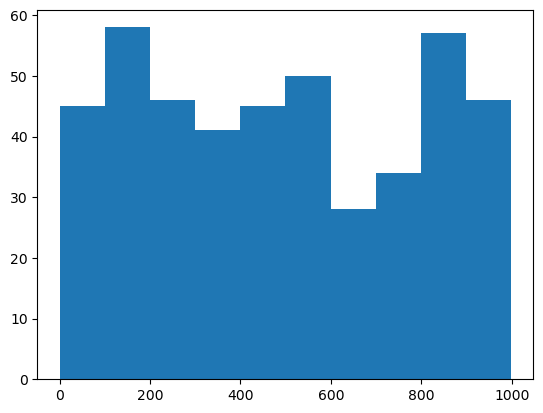

In [12]:
plt.hist(balanced_mesh_ids, bins = 10);

In [13]:
class FilteredTwoHeadedDataset(TwoHeadedDataset):
    def __init__(self, mesh_dir, csv_path, selected_mesh_ids, **kwargs):
        super().__init__(mesh_dir, csv_path, **kwargs)

        # Override mesh_ids with the provided list (with duplicates)
        self.mesh_ids = selected_mesh_ids




dataset = FilteredTwoHeadedDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/pattern_and_pca.csv",
    selected_mesh_ids=balanced_mesh_ids)
print(f"{len(dataset)} graphs loaded")

450 graphs loaded


## Visualize few samples in the dataset

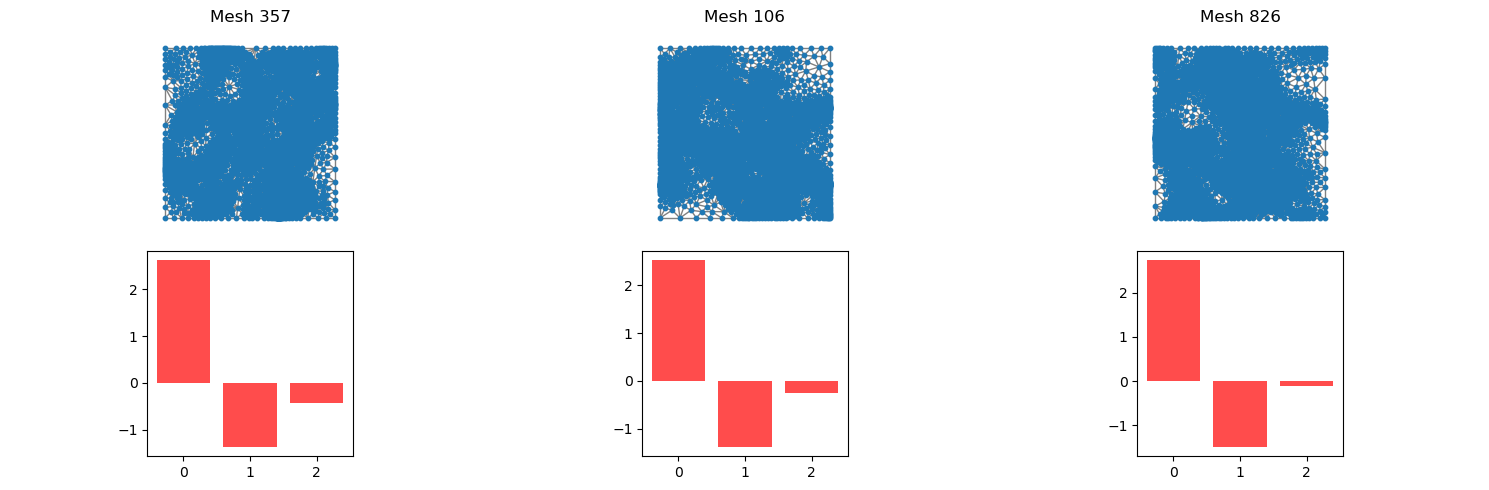

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i+55]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y_time)),data.y_time.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Create the model

Import needed packages

In [ ]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool, global_add_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

from torch import nn
from torch_geometric.nn import EdgeConv
from torch_scatter import scatter_add

# Classification Learning Model

Split data and make dataset for  batch training. Pre-select and save batches (for relatively small datasets).

In [19]:
# Set random seed for reproducibility
torch.manual_seed(24)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


batch_size = 64  # Set to 450 for full batch, or specify a number for mini-batches

def create_static_batches(dataset, batch_size):
    batches = []
    for i in range(0, len(dataset), batch_size):
        with contextlib.redirect_stdout(None):
            batch = Batch.from_data_list(dataset[i:i+batch_size])
        batches.append(batch)
    return batches

train_batches = create_static_batches(train_dataset, batch_size=batch_size)
test_batches = create_static_batches(test_dataset, batch_size=batch_size)

print(f"Pre-batched {len(train_batches)} train batches and {len(test_batches)} test batches")


Pre-batched 6 train batches and 2 test batches


In [20]:
train_nodes = []
train_edges = []

with contextlib.redirect_stdout(None):
        for data in train_dataset:
                train_nodes.append(data.num_nodes)
                train_edges.append(data.edge_index.size(1))

min_nodes = min(train_nodes)
max_nodes = max(train_nodes)
min_edges = min(train_edges)
max_edges = max(train_edges)

print(f"Node count: min={min_nodes}, max={max_nodes}")
print(f"Edge count: min={min_edges}, max={max_edges}")


Node count: min=3282, max=20893
Edge count: min=19347, max=124446


In [21]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[7210, 3], edge_index=[2, 42759], y_time=[3], y_conv=[1], mesh_id=888)

Data(x=[7438, 3], edge_index=[2, 44235], y_time=[3], y_conv=[1], mesh_id=659)

Data(x=[7008, 3], edge_index=[2, 41211], y_time=[3], y_conv=[1], mesh_id=484)

Data(x=[5238, 3], edge_index=[2, 30786], y_time=[3], y_conv=[1], mesh_id=178)

Data(x=[5012, 3], edge_index=[2, 29466], y_time=[3], y_conv=[1], mesh_id=99)


# Classification Model

In [ ]:
class EdgeMeshClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_classes=9, 
                 min_nodes=0, max_nodes=1, min_edges=0, max_edges=1):
        super().__init__()
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.min_edges = min_edges
        self.max_edges = max_edges

        # Using LayerNorm for stability with graphs
        #self.ln1 = nn.LayerNorm(hidden_dim)
        #self.ln2 = nn.LayerNorm(hidden_dim)
   
        self.conv1 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv2 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        self.lin1 = nn.Linear(2*hidden_dim + 2, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.conv_head = nn.Linear(hidden_dim, num_classes, bias=False)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
      
        x_mean = global_add_pool(x, batch)/self.max_nodes
        x_max = global_max_pool(x, batch)
        x_pool = torch.cat([x_mean, x_max], dim=1)  # Shape: [batch_size, 2 * hidden_dim]
     

        num_nodes = scatter_add(torch.ones_like(batch), batch, dim=0).unsqueeze(1)
        row, _ = edge_index
        edge_batch = batch[row]
        num_edges = scatter_add(torch.ones_like(edge_batch), edge_batch, dim=0).unsqueeze(1)

        num_nodes = (num_nodes - self.min_nodes) / (self.max_nodes - self.min_nodes)
        num_edges = (num_edges - self.min_edges) / (self.max_edges - self.min_edges)

        x_combined = torch.cat([x_pool, num_nodes, num_edges], dim=1)
        x_combined = self.relu(self.lin1(x_combined))
        x_combined = self.dropout(x_combined)

        y_conv_logits = self.conv_head(x_combined)
        return y_conv_logits



def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Train the model

In [104]:
def train_epoch_static_classification(model, batches, optimizer, device):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    for batch in batches:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_conv_logits = model(batch.x, batch.edge_index, batch.batch)  # [B, num_classes]
        y_conv_true = batch.y_conv.view(-1)  # [B], long tensor with class indices

        loss = criterion(y_conv_logits, y_conv_true)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)


def evaluate_epoch_static_classification(model, batches, device):
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in batches:
            batch = batch.to(device)
            y_conv_logits = model(batch.x, batch.edge_index, batch.batch)
            y_conv_true = batch.y_conv.view(-1)

            loss = criterion(y_conv_logits, y_conv_true)
            total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)

def evaluate_accuracy_static(model, batches, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in batches:
            batch = batch.to(device)
            y_conv_logits = model(batch.x, batch.edge_index, batch.batch)
            preds = y_conv_logits.argmax(dim=1)  # Predicted classes
            correct += (preds == batch.y_conv.view(-1)).sum().item()
            total += batch.num_graphs
    return correct / total



In [319]:
gnn_model = EdgeMeshClassifier(
     input_dim = 3,
     hidden_dim = 64,
     num_classes = 9,
     min_nodes= min_nodes,
     max_nodes=max_nodes, 
     min_edges = min_edges,
     max_edges=max_edges
 ).to(device)

gnn_model.apply(init_weights)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

EdgeMeshClassifier(
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=64, bias=False)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=False)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (lin1): Linear(in_features=130, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (conv_head): Linear(in_features=64, out_features=9, bias=False)
)
Number of trainable parameters: 25856


In [320]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

In [321]:
n_epochs = 300

for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    train_loss = train_epoch_static_classification(gnn_model, train_batches, optimizer, device)
    t1 = time.time()
    test_loss = evaluate_epoch_static_classification(gnn_model, test_batches, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


    scheduler.step(test_loss)

    train_acc = evaluate_accuracy_static(gnn_model, train_batches, device)
    test_acc = evaluate_accuracy_static(gnn_model, test_batches, device)
   
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    #print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time Spent: {t1-t0:.2f} s")
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} "
          f"| Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Time Spent: {t1-t0:.2f} s")


Epoch 001 | Train Loss: 2.2644 | Test Loss: 2.2108 | Train Acc: 0.086 | Test Acc: 0.111 | Time Spent: 58.71 s
Epoch 002 | Train Loss: 2.1961 | Test Loss: 2.2028 | Train Acc: 0.103 | Test Acc: 0.078 | Time Spent: 57.44 s
Epoch 003 | Train Loss: 2.1803 | Test Loss: 2.1923 | Train Acc: 0.158 | Test Acc: 0.111 | Time Spent: 57.50 s
Epoch 004 | Train Loss: 2.1655 | Test Loss: 2.1738 | Train Acc: 0.203 | Test Acc: 0.167 | Time Spent: 57.55 s
Epoch 005 | Train Loss: 2.1638 | Test Loss: 2.1628 | Train Acc: 0.219 | Test Acc: 0.167 | Time Spent: 57.10 s
Epoch 006 | Train Loss: 2.1355 | Test Loss: 2.1492 | Train Acc: 0.219 | Test Acc: 0.144 | Time Spent: 57.21 s
Epoch 007 | Train Loss: 2.1362 | Test Loss: 2.1331 | Train Acc: 0.253 | Test Acc: 0.167 | Time Spent: 57.21 s
Epoch 008 | Train Loss: 2.1106 | Test Loss: 2.1131 | Train Acc: 0.233 | Test Acc: 0.178 | Time Spent: 57.21 s
Epoch 009 | Train Loss: 2.0917 | Test Loss: 2.0854 | Train Acc: 0.239 | Test Acc: 0.211 | Time Spent: 57.29 s
Epoch 010 

In [322]:
for name, param in gnn_model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean())


conv1.nn.0.weight tensor(0.0041, device='cuda:0')
conv1.nn.2.weight tensor(0.0026, device='cuda:0')
conv1.nn.2.bias tensor(0.0263, device='cuda:0')
conv2.nn.0.weight tensor(0.0028, device='cuda:0')
conv2.nn.2.weight tensor(0.0066, device='cuda:0')
conv2.nn.2.bias tensor(0.0092, device='cuda:0')
lin1.weight tensor(0.0090, device='cuda:0')
lin1.bias tensor(0.0043, device='cuda:0')
conv_head.weight tensor(0.0163, device='cuda:0')


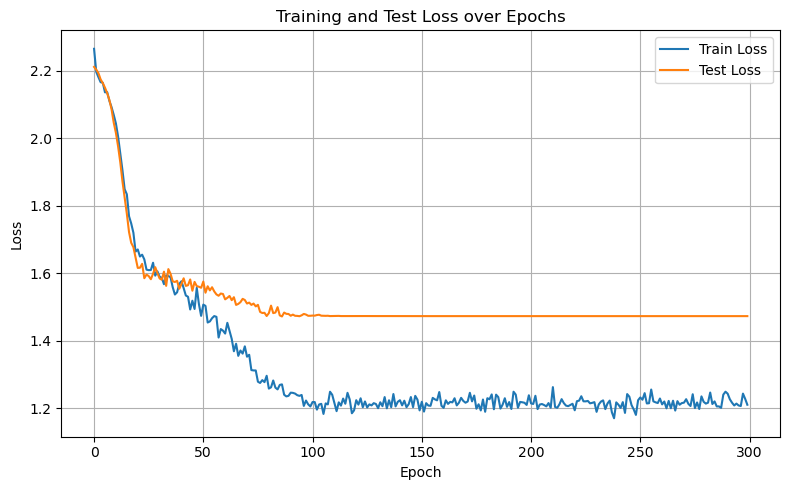

In [323]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses[0:], label='Train Loss')
plt.plot(test_losses[0:], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


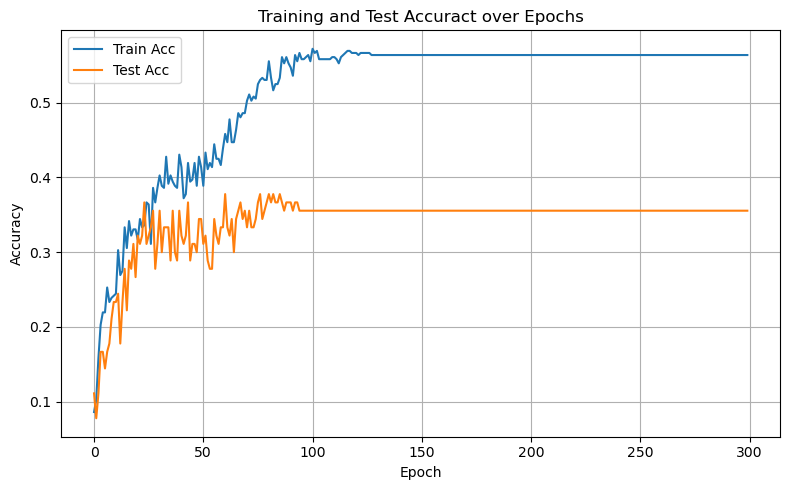

In [332]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies[0:], label='Train Acc')
plt.plot(test_accuracies[0:], label='Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuract over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Understand Predicitons

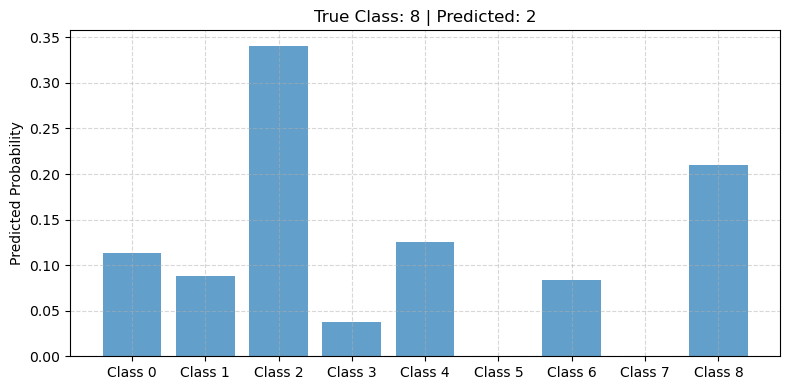

In [327]:
# Select one sample from test_dataset
data = test_dataset[1].to(device)

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_conv_logits = gnn_model(data.x, data.edge_index, batch_vector)
    y_conv_probs = F.softmax(y_conv_logits, dim=1).squeeze(0)  # [num_classes]
    predicted_class = y_conv_probs.argmax().item()

# Ground truth class
true_class = data.y_conv.item()

# Convert to NumPy
y_conv_probs = y_conv_probs.cpu().numpy()

# Plot
plt.figure(figsize=(8, 4))
indices = range(len(y_conv_probs))

plt.bar(indices, y_conv_probs, alpha=0.7)
plt.xticks(indices, [f"Class {i}" for i in indices])
plt.ylabel("Predicted Probability")
plt.title(f"True Class: {true_class} | Predicted: {predicted_class}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [331]:
print(f"Learning Rate = {optimizer.param_groups[0]['lr']:.9f}")

Learning Rate = 0.000000015


## Model For Regression

In [301]:
class EdgeMeshRegressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3, 
                 min_nodes=0, max_nodes=1, min_edges=0, max_edges=1):
        super().__init__()
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.min_edges = min_edges
        self.max_edges = max_edges

        # Using LayerNorm for stability with graphs
        #self.ln1 = nn.LayerNorm(hidden_dim)
        #self.ln2 = nn.LayerNorm(hidden_dim)
   
        self.conv1 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv2 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        self.lin1 = nn.Linear(2*hidden_dim + 2, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.time_head = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
      
        x_mean = global_add_pool(x, batch)/self.max_nodes
        x_max = global_max_pool(x, batch)
        x_pool = torch.cat([x_mean, x_max], dim=1)  # Shape: [batch_size, 2 * hidden_dim]
     

        num_nodes = scatter_add(torch.ones_like(batch), batch, dim=0).unsqueeze(1)
        row, _ = edge_index
        edge_batch = batch[row]
        num_edges = scatter_add(torch.ones_like(edge_batch), edge_batch, dim=0).unsqueeze(1)

        num_nodes = (num_nodes - self.min_nodes) / (self.max_nodes - self.min_nodes)
        num_edges = (num_edges - self.min_edges) / (self.max_edges - self.min_edges)

        x_combined = torch.cat([x_pool, num_nodes, num_edges], dim=1)
        x_combined = self.relu(self.lin1(x_combined))
        x_combined = self.dropout(x_combined)

        y_time = self.time_head(x_combined)
        return y_time



def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [255]:
def train_epoch_static_regression(model, batches, optimizer, device):
    model.train()
    total_loss = 0
    criterion = nn.MSELoss()
    for batch in batches:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_time_pred = model(batch.x, batch.edge_index, batch.batch)  # [B, 3]
        y_time_true = batch.y_time.view(-1,3)  # [B, 3]

        loss = criterion(y_time_pred, y_time_true)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)

def evaluate_epoch_static_regression(model, batches, device):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in batches:
            batch = batch.to(device)
            y_time_pred = model(batch.x, batch.edge_index, batch.batch)
            y_time_true = batch.y_time.view(-1,3)

            loss = criterion(y_time_pred, y_time_true)
            total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)


In [313]:
gnnR_model = EdgeMeshRegressor(
     input_dim = 3,
     hidden_dim = 128,
     output_dim = 3,
     min_nodes= min_nodes,
     max_nodes=max_nodes, 
     min_edges = min_edges,
     max_edges=max_edges
 ).to(device)

gnnR_model.apply(init_weights)

print(gnnR_model)

num_params = sum(p.numel() for p in gnnR_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

optimizer = torch.optim.Adam(gnnR_model.parameters(), lr=0.001,weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

EdgeMeshRegressor(
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (lin1): Linear(in_features=258, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (time_head): Linear(in_features=128, out_features=3, bias=False)
)
Number of trainable parameters: 100096


In [314]:
train_losses = []
test_losses = []

In [310]:
n_epochs = 5

for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    train_loss = train_epoch_static_regression(gnnR_model, train_batches, optimizer, device)
    t1 = time.time()
    test_loss = evaluate_epoch_static_regression(gnnR_model, test_batches, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | Time Spent: {t1 - t0:.2f} s")


Epoch 001 | Train Loss: 5.566437 | Test Loss: 5.107875 | Time Spent: 15.03 s
Epoch 002 | Train Loss: 5.557347 | Test Loss: 5.092828 | Time Spent: 14.63 s
Epoch 003 | Train Loss: 5.552857 | Test Loss: 5.082509 | Time Spent: 14.50 s
Epoch 004 | Train Loss: 5.542733 | Test Loss: 5.070801 | Time Spent: 14.62 s
Epoch 005 | Train Loss: 5.531378 | Test Loss: 5.056757 | Time Spent: 14.99 s


In [329]:
print(f"Learning Rate = {optimizer.param_groups[0]['lr']:.9f}")

Learning Rate = 0.000000015


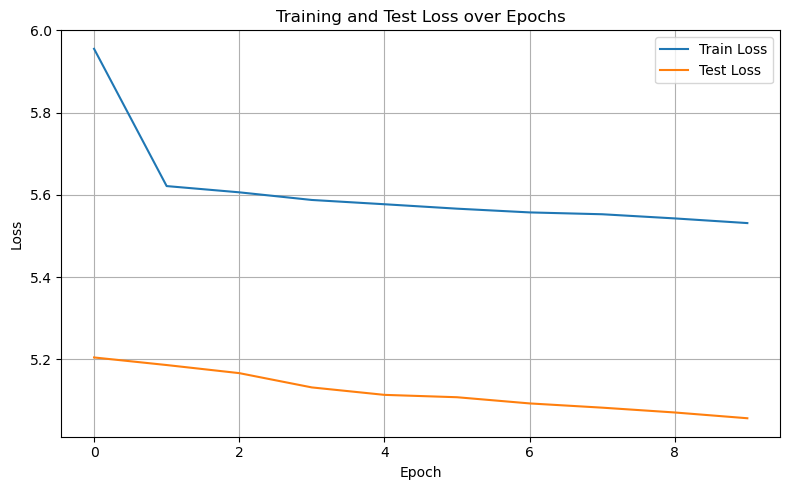

In [312]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses[0:], label='Train Loss')
plt.plot(test_losses[0:], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


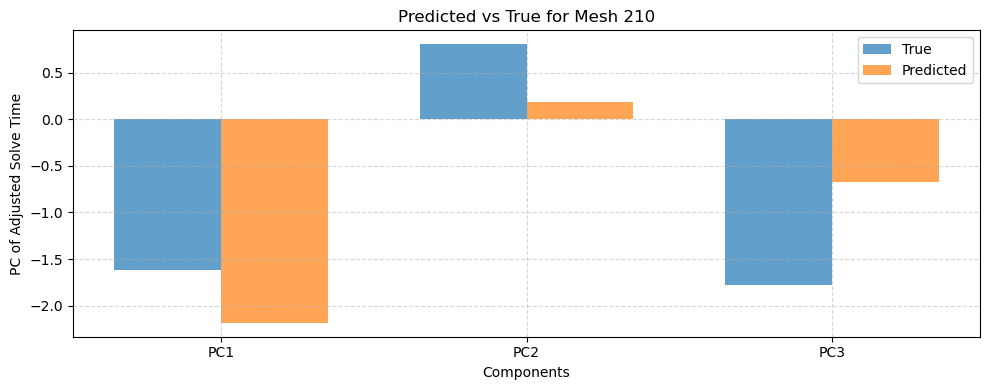

In [287]:
# Select one sample from test_dataset
data = test_dataset[-1].to(device)

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

# Model to eval mode
gnnR_model.eval()
with torch.no_grad():
    y_pred = gnnR_model(data.x, data.edge_index, batch_vector).squeeze()
    y_true = data.y_time

# Convert to NumPy for plotting
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_true))

labels =['PC1', 'PC2', 'PC3']

plt.bar([i - width/2 for i in indices], y_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_pred, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Components")
plt.xticks(indices, labels, rotation=0)
plt.ylabel("PC of Adjusted Solve Time")
plt.title(f"Predicted vs True for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()
